### The main idea es predict whether spacex will attempt to land a rocket or not using Spacex API Rest

In [69]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

### From the SpaceX API

In [44]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)

In [45]:
data = pd.json_normalize(response.json())
data.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,...,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],Ratsat was carried to orbit on the first succe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=dLQ2tZEH6G0,dLQ2tZEH6G0,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,NaN
4,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,True,[],None,[],[],...,None,None,[],[],http://www.spacex.com/press/2012/12/19/spacexs...,https://www.youtube.com/watch?v=yTaIDooc8Og,yTaIDooc8Og,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,NaN


In [46]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len) == 1]
data = data[data['payloads'].map(len) == 1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

In [47]:
data.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight':...",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight':...",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight':...",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight':...",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight':...",6,2010-06-04T18:45:00.000Z,2010-06-04


In [48]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
# From the rocket column we would like to learn the booster name.
BoosterVersion = []
def getBoosterVersion(data):
    for x in data['rocket']:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

In [49]:
Longitude, Latitude, LaunchSite = [], [], []
def getLaunchSite(data):
    for x in data['launchpad']:
        response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
        Longitude.append(response['longitude'])
        Latitude.append(response['latitude'])
        LaunchSite.append(response['name'])

In [50]:
PayloadMass, Orbit = [], []
def getPayloadData(data):
    for load in data['payloads']:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

In [51]:
Block, ReusedCount, Serial, Outcome, Flights, GridFins, Reused, Legs, LandingPad = [], [], [], [], [], [], [], [], []
def getCoreData(data):
    for core in data['cores']:
        if core['core'] != None:
            response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
            Block.append(response['block'])
            ReusedCount.append(response['reuse_count'])
            Serial.append(response['serial'])
        else:
            Block.append(None)
            ReusedCount.append(None)
            Serial.append(None)
        Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
        Flights.append(core['flight'])
        GridFins.append(core['gridfins'])
        Reused.append(core['reused'])
        Legs.append(core['legs'])
        LandingPad.append(core['landpad'])

In [52]:
getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

In [53]:
launch_dict = {'FlightNumber': list(data['flight_number']),
               'Date': list(data['date']),
               'BoosterVersion':BoosterVersion,
               'PayloadMass':PayloadMass,
               'Orbit':Orbit,
               'LaunchSite':LaunchSite,
               'Outcome':Outcome,
               'Flights':Flights,
               'GridFins':GridFins,
               'Reused':Reused,
               'Legs':Legs,
               'LandingPad':LandingPad,
               'Block':Block,
               'ReusedCount':ReusedCount,
               'Serial':Serial,
               'Longitude': Longitude,
               'Latitude': Latitude}

In [54]:
df = pd.DataFrame.from_dict(launch_dict)
df

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,152,2022-03-03,Falcon 9,13260.0,VLEO,KSC LC 39A,True ASDS,11,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,10,B1060,-80.603956,28.608058
139,153,2022-03-09,Falcon 9,13260.0,VLEO,CCSFS SLC 40,True ASDS,4,True,True,True,5e9e3033383ecb075134e7cd,5.0,3,B1052,-80.577366,28.561857
140,154,2022-03-19,Falcon 9,13260.0,VLEO,CCSFS SLC 40,True ASDS,12,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,11,B1051,-80.577366,28.561857
141,155,2022-04-01,Falcon 9,NaN,SSO,CCSFS SLC 40,True ASDS,7,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,6,B1061,-80.577366,28.561857


Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches

In [55]:
df = df[df['BoosterVersion'] != 'Falcon 1']
df.loc[:,'FlightNumber'] = list(range(1, df.shape[0]+1))
df

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,135,2022-03-03,Falcon 9,13260.0,VLEO,KSC LC 39A,True ASDS,11,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,10,B1060,-80.603956,28.608058
139,136,2022-03-09,Falcon 9,13260.0,VLEO,CCSFS SLC 40,True ASDS,4,True,True,True,5e9e3033383ecb075134e7cd,5.0,3,B1052,-80.577366,28.561857
140,137,2022-03-19,Falcon 9,13260.0,VLEO,CCSFS SLC 40,True ASDS,12,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,11,B1051,-80.577366,28.561857
141,138,2022-04-01,Falcon 9,NaN,SSO,CCSFS SLC 40,True ASDS,7,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,6,B1061,-80.577366,28.561857


In [56]:
df.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass       17
Orbit              1
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [57]:
# Calculate the mean value of PayloadMass column
payload_mean = df['PayloadMass'].mean()
df['PayloadMass'] = df['PayloadMass'].replace(np.nan, payload_mean)

### Data Wrangling
In the data set, there are several different cases where the booster did not land successfully. Sometimes a landing was attempted but failed due to an accident; for example, True Ocean means the mission outcome was successfully  landed to a specific region of the ocean while False Ocean means the mission outcome was unsuccessfully landed to a specific region of the ocean. True RTLS means the mission outcome was successfully  landed to a ground pad False RTLS means the mission outcome was unsuccessfully landed to a ground pad.True ASDS means the mission outcome was successfully landed on  a drone ship False ASDS means the mission outcome was unsuccessfully landed on a drone ship.

In this project we will mainly convert those outcomes into Training Labels with `1` means the booster successfully landed `0` means it was unsuccessful.


In [58]:
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

True ASDS      83
True RTLS      20
None None      19
False ASDS      7
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

In [59]:
for i, outcome in enumerate(landing_outcomes.keys()):
    print(i, outcome)

0 True ASDS
1 True RTLS
2 None None
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [60]:
bad_outcomes= set(landing_outcomes.keys()[[2,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [61]:
landing_class = df['Outcome'].map(lambda x: 0 if x in bad_outcomes else 1)
df['Class'] = landing_class
df[['Class']]

,Class
4,0
5,0
6,0
7,0
8,0
...,...
138,1
139,1
140,1
141,1


In [62]:
df

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,7647.061885,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,135,2022-03-03,Falcon 9,13260.000000,VLEO,KSC LC 39A,True ASDS,11,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,10,B1060,-80.603956,28.608058,1
139,136,2022-03-09,Falcon 9,13260.000000,VLEO,CCSFS SLC 40,True ASDS,4,True,True,True,5e9e3033383ecb075134e7cd,5.0,3,B1052,-80.577366,28.561857,1
140,137,2022-03-19,Falcon 9,13260.000000,VLEO,CCSFS SLC 40,True ASDS,12,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,11,B1051,-80.577366,28.561857,1
141,138,2022-04-01,Falcon 9,7647.061885,SSO,CCSFS SLC 40,True ASDS,7,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,6,B1061,-80.577366,28.561857,1


### Some data visualizations
Visualize the relationship between success rate of each feature

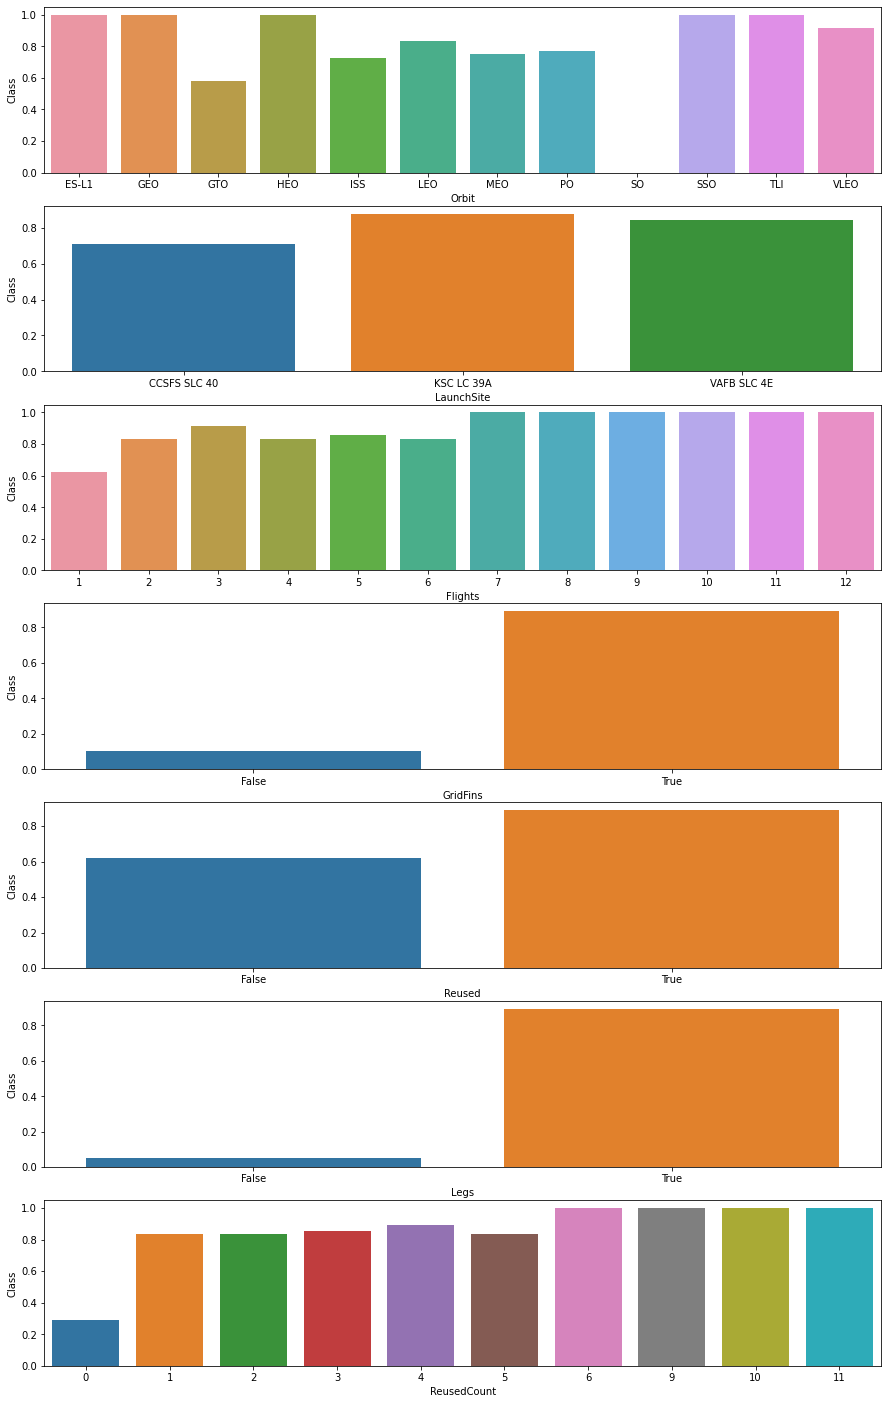

In [63]:
features = ['Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'ReusedCount']
fig, axes = plt.subplots(len(features), 1, figsize=(15,25))
for i in enumerate(features):
    df_group = df.groupby([i[1]], as_index=False).mean()
    sns.barplot(x=i[1], y="Class", data=df_group, ax=axes[i[0]])

<AxesSubplot:xlabel='FlightNumber', ylabel='PayloadMass'>

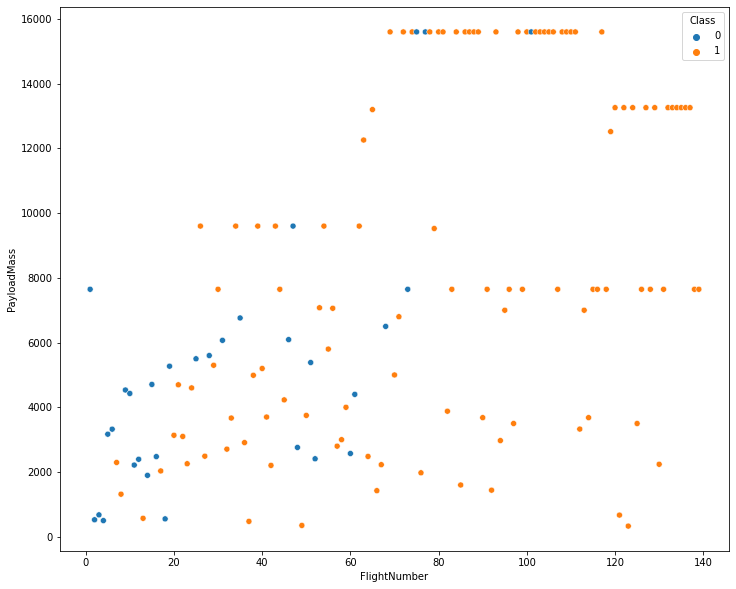

In [64]:
plt.figure(figsize=(12, 10))
sns.scatterplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df)

In [65]:
df = pd.get_dummies(df, columns=['Orbit', 'LaunchSite'], drop_first=False)
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Outcome,Flights,GridFins,Reused,Legs,LandingPad,...,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_TLI,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E
4,1,2010-06-04,Falcon 9,7647.061885,None None,1,False,False,False,None,...,1,0,0,0,0,0,0,1,0,0
5,2,2012-05-22,Falcon 9,525.000000,None None,1,False,False,False,None,...,1,0,0,0,0,0,0,1,0,0
6,3,2013-03-01,Falcon 9,677.000000,None None,1,False,False,False,None,...,0,0,0,0,0,0,0,1,0,0
7,4,2013-09-29,Falcon 9,500.000000,False Ocean,1,False,False,False,None,...,0,0,1,0,0,0,0,0,0,1
8,5,2013-12-03,Falcon 9,3170.000000,None None,1,False,False,False,None,...,0,0,0,0,0,0,0,1,0,0


In [66]:
df['GridFins'] = df['GridFins'].map(lambda x: 0 if x is False else 1)
df['Reused'] = df['Reused'].map(lambda x: 0 if x is False else 1)
df['Legs'] = df['Legs'].map(lambda x: 0 if x is False else 1)
df['Serial'] = df['Serial'].map(lambda x: int(x[1:]))
df

,FlightNumber,Date,BoosterVersion,PayloadMass,Outcome,Flights,GridFins,Reused,Legs,LandingPad,...,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_TLI,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E
4,1,2010-06-04,Falcon 9,7647.061885,None None,1,0,0,0,None,...,1,0,0,0,0,0,0,1,0,0
5,2,2012-05-22,Falcon 9,525.000000,None None,1,0,0,0,None,...,1,0,0,0,0,0,0,1,0,0
6,3,2013-03-01,Falcon 9,677.000000,None None,1,0,0,0,None,...,0,0,0,0,0,0,0,1,0,0
7,4,2013-09-29,Falcon 9,500.000000,False Ocean,1,0,0,0,None,...,0,0,1,0,0,0,0,0,0,1
8,5,2013-12-03,Falcon 9,3170.000000,None None,1,0,0,0,None,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,135,2022-03-03,Falcon 9,13260.000000,True ASDS,11,1,1,1,5e9e3033383ecbb9e534e7cc,...,0,0,0,0,0,0,1,0,1,0
139,136,2022-03-09,Falcon 9,13260.000000,True ASDS,4,1,1,1,5e9e3033383ecb075134e7cd,...,0,0,0,0,0,0,1,1,0,0
140,137,2022-03-19,Falcon 9,13260.000000,True ASDS,12,1,1,1,5e9e3033383ecbb9e534e7cc,...,0,0,0,0,0,0,1,1,0,0
141,138,2022-04-01,Falcon 9,7647.061885,True ASDS,7,1,1,1,5e9e3033383ecbb9e534e7cc,...,0,0,0,0,1,0,0,1,0,0


### Predictive analysis using different classification models

In [71]:
# Standardize the data
standard = ['PayloadMass', 'Serial']
scaler = MinMaxScaler(feature_range=(0,1))
for i in standard:
    scaler = scaler.fit(df[[i]])
    df[i] = scaler.transform(df[[i]])
df

,FlightNumber,Date,BoosterVersion,PayloadMass,Outcome,Flights,GridFins,Reused,Legs,LandingPad,...,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_TLI,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E
4,1,2010-06-04,Falcon 9,0.479179,None None,1,0,0,0,None,...,1,0,0,0,0,0,0,1,0,0
5,2,2012-05-22,Falcon 9,0.012770,None None,1,0,0,0,None,...,1,0,0,0,0,0,0,1,0,0
6,3,2013-03-01,Falcon 9,0.022724,None None,1,0,0,0,None,...,0,0,0,0,0,0,0,1,0,0
7,4,2013-09-29,Falcon 9,0.011133,False Ocean,1,0,0,0,None,...,0,0,1,0,0,0,0,0,0,1
8,5,2013-12-03,Falcon 9,0.185986,None None,1,0,0,0,None,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,135,2022-03-03,Falcon 9,0.846758,True ASDS,11,1,1,1,5e9e3033383ecbb9e534e7cc,...,0,0,0,0,0,0,1,0,1,0
139,136,2022-03-09,Falcon 9,0.846758,True ASDS,4,1,1,1,5e9e3033383ecb075134e7cd,...,0,0,0,0,0,0,1,1,0,0
140,137,2022-03-19,Falcon 9,0.846758,True ASDS,12,1,1,1,5e9e3033383ecbb9e534e7cc,...,0,0,0,0,0,0,1,1,0,0
141,138,2022-04-01,Falcon 9,0.479179,True ASDS,7,1,1,1,5e9e3033383ecbb9e534e7cc,...,0,0,0,0,1,0,0,1,0,0


In [72]:
df

,FlightNumber,Date,BoosterVersion,PayloadMass,Outcome,Flights,GridFins,Reused,Legs,LandingPad,...,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_TLI,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E
4,1,2010-06-04,Falcon 9,0.479179,None None,1,0,0,0,None,...,1,0,0,0,0,0,0,1,0,0
5,2,2012-05-22,Falcon 9,0.012770,None None,1,0,0,0,None,...,1,0,0,0,0,0,0,1,0,0
6,3,2013-03-01,Falcon 9,0.022724,None None,1,0,0,0,None,...,0,0,0,0,0,0,0,1,0,0
7,4,2013-09-29,Falcon 9,0.011133,False Ocean,1,0,0,0,None,...,0,0,1,0,0,0,0,0,0,1
8,5,2013-12-03,Falcon 9,0.185986,None None,1,0,0,0,None,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,135,2022-03-03,Falcon 9,0.846758,True ASDS,11,1,1,1,5e9e3033383ecbb9e534e7cc,...,0,0,0,0,0,0,1,0,1,0
139,136,2022-03-09,Falcon 9,0.846758,True ASDS,4,1,1,1,5e9e3033383ecb075134e7cd,...,0,0,0,0,0,0,1,1,0,0
140,137,2022-03-19,Falcon 9,0.846758,True ASDS,12,1,1,1,5e9e3033383ecbb9e534e7cc,...,0,0,0,0,0,0,1,1,0,0
141,138,2022-04-01,Falcon 9,0.479179,True ASDS,7,1,1,1,5e9e3033383ecbb9e534e7cc,...,0,0,0,0,1,0,0,1,0,0


In [95]:
df_dummies = df[list(df.columns[16:])]

In [117]:
x = df[['PayloadMass', 'Flights', 'GridFins', 'Reused', 'Legs', 'ReusedCount', 'Serial']]
x = x.add(df_dummies, fill_value=0)
y = df['Class']

In [118]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=1)

In [122]:
def plot_confusion_matrix(y ,y_predict):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

Logistic regression

In [104]:
parameters ={"C":[0.01,0.1,1], 'penalty':['l2'], 'solver':['lbfgs']}
lr=LogisticRegression()

In [105]:
grid_1 = GridSearchCV(lr, parameters, cv=4)

In [106]:
grid_1.fit(x_train, y_train)

GridSearchCV(cv=4, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [121]:
best_estimator=grid_1.best_estimator_
print("tuned hpyerparameters :(best parameters) ", grid_1.best_params_)
print("accuracy for the best estimator :", round(best_estimator.score(x_test, y_test),4) * 100,'% percent')

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy for the best estimator : 92.86 % percent


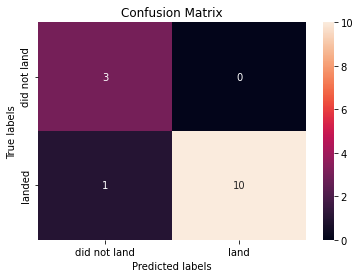

In [123]:
yhat = best_estimator.predict(x_test)
plot_confusion_matrix(y_test,yhat)

Support Vector Machine

In [124]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [125]:
grid_2 = GridSearchCV(svm, parameters, cv=4)
grid_2.fit(x_train, y_train)

GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [126]:
best_estimator=grid_2.best_estimator_
print("tuned hpyerparameters :(best parameters) ", grid_2.best_params_)
print("accuracy for the best estimator :", round(best_estimator.score(x_test, y_test),4) * 100,'% percent')

tuned hpyerparameters :(best parameters)  {'C': 0.03162277660168379, 'gamma': 1.0, 'kernel': 'poly'}
accuracy for the best estimator : 92.86 % percent


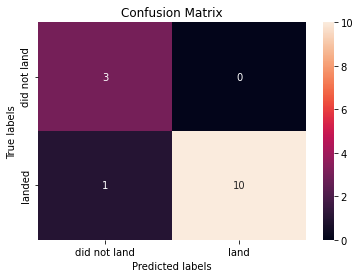

In [127]:
yhat = best_estimator.predict(x_test)
plot_confusion_matrix(y_test,yhat)

Decision Tree Classifier

In [128]:
parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [2*n for n in range(1,10)],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [129]:
grid_3 = GridSearchCV(tree, parameters, cv=4)
grid_3.fit(x_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [130]:
best_estimator=grid_3.best_estimator_
print("tuned hpyerparameters :(best parameters) ", grid_3.best_params_)
print("accuracy for the best estimator :", round(best_estimator.score(x_test, y_test),4) * 100,'% percent')

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy for the best estimator : 85.71 % percent


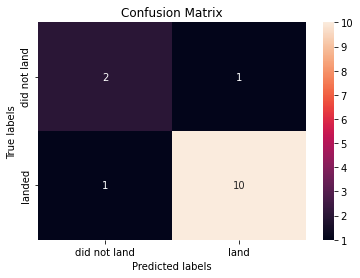

In [131]:
yhat = best_estimator.predict(x_test)
plot_confusion_matrix(y_test,yhat)

k nearest neighbors

In [132]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [133]:
grid_4 = GridSearchCV(KNN, parameters, cv=4)
grid_4.fit(x_train, y_train)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [134]:
best_estimator=grid_4.best_estimator_
print("tuned hpyerparameters :(best parameters) ", grid_4.best_params_)
print("accuracy for the best estimator :", round(best_estimator.score(x_test, y_test),4) * 100,'% percent')

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 2}
accuracy for the best estimator : 85.71 % percent


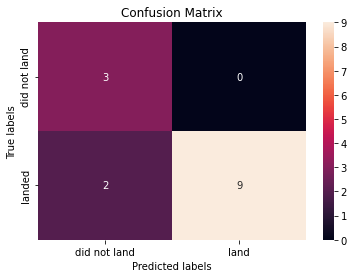

In [135]:
yhat = best_estimator.predict(x_test)
plot_confusion_matrix(y_test,yhat)

### We choose the SVM model as the better model to model this Dataset and try to predict if a Launch will be success or nor

In [136]:
model = grid_2.best_estimator_